In [1]:
from dateutil.relativedelta import relativedelta
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Set up plotting
current_palette = sns.color_palette()
LANGUAGE_COLORS = {
    "Chinese": current_palette[0],
    "English": current_palette[1],
    "Spanish": current_palette[2],
    "Sign": current_palette[3],
    "Animal Sound": current_palette[4],
}

# Set plotting style
sns.set_style("white")

# Plot constants
WIDTH = 12
HEIGHT = 7

# Plot constants
X_MIN, X_MAX = (736545.2, 736980.8)
Y_MIN, Y_MAX = (0.38041005786659937, 256.8277838060705)

%matplotlib inline

In [3]:
BIRTHDAY = datetime.date(2016, 6, 1)

In [4]:
words_df = pd.read_csv(
    "./theo_words.csv",
    names=["timestamp", "word", "language", "first_use"],
    header=0,
    parse_dates=["timestamp", "first_use"],
)

## Normalize the data

In [5]:
# Sort by first use
words_df = words_df.sort_values("first_use")

# Lowercase all words
words_df["word"] = words_df["word"].str.lower().str.strip()

# Remove paranthetical remarks
words_df["word"] = words_df["word"].str.split('(').str[0].str.strip()

# Save the first duplicate, remove the rest
words_df = words_df.drop_duplicates(subset=["language", "word"])
words_df = words_df.reset_index(drop=True)

In [6]:
# Sort by first_use date and then cumulative count
words_df = words_df.sort_values("first_use")
words_df["count"] = words_df.groupby("language").cumcount()
# `.cumcount()` starts from 0, but we want the first word to be 1
words_df["count"] += 1

cumulative_df = words_df[["language", "first_use", "count"]].groupby(["language", "first_use"]).max()

# Fillin missing days
before_first_day = pd.Timestamp(year=2017, month=9, day=1)
min_day = words_df["first_use"].min()
max_day = words_df["first_use"].max()
all_days = pd.date_range(before_first_day, max_day, freq='D')

# This is a really really bad hack...
hacked_df = pd.DataFrame({})
for language in cumulative_df.index.get_level_values("language").unique():
    result = cumulative_df.loc[language].reindex(all_days)
    result["language"] = language
    result.at[before_first_day, "count"] = 0
    result = result.reset_index()
    result = result.fillna(method="ffill").fillna(method="bfill")
    if hacked_df.empty:
        hacked_df = result
    else:
        hacked_df = pd.concat([hacked_df, result])

language_day_count_df = hacked_df.rename(columns={"index": "first_use"})

## Some plotting functions

In [7]:
def word_coordinates(df, count_df, word, language):
    """Return the timestamp of first useage, and the number of words known in
    the language at the time, for a given word.
    
    Args:
        df (dateframe): A dataframe with a "language", "word", and "first_use" columns.
        df_count (dateframe): A dataframe with a "language", "first_use", and "count" columns.
        word (str): The word to select.
        lanague (str): The language to select the word from.
    """
    correct_langauge = df["language"]==language

    compare_word = word.lower()
    correct_word = df["word"].str.contains(compare_word)

    filtered = df[correct_langauge & correct_word]
    timestamp = filtered["first_use"]

    # Join on the timestamp
    merged = pd.merge(filtered, count_df, on=["first_use", "language"])

    return timestamp.values[0], merged["count_y"].values[0]

In [8]:
def draw_legend(plt):
    """Draw the legend on the specified plot.

    Args:
        plt (matplotlib.pyplot): pyplot object
    """
    leg = plt.legend(
        loc="upper left",
        fontsize=18,
        ncol=1,
        frameon=1,
        fancybox=True,
        # The bellow commands remove the lines in the legend
        handlelength=0,
        handletextpad=0,
        markerscale=0,
    )

    # Turn on and theme the frame
    frame = leg.get_frame()
    frame.set_linewidth(1)
    frame.set_alpha(1)
    frame.set_facecolor('white')
    frame.set_edgecolor('black')

    # Set the legend text color to match the line color
    handles, _ = ax.get_legend_handles_labels()
    texts = leg.get_texts()
    for _, text in zip(handles, texts):
        text.set_color(LANGUAGE_COLORS[text.get_text()])

    fig.tight_layout()

In [9]:
def age_to_timestamp(age, born=BIRTHDAY):
    """Returns a datetime date for when Theo turned a specific age in months.

    Args:
        age (int): The age in months.
        born (datetime.date, optional): Birth date of the person.

    Returns:
       datetime.date: The day on which the age in months begins. 
    """
    current = born + relativedelta(months=age)

    return current

In [10]:
def draw_bands(ax, width=1):
    """Add grey bands to the plot with a specified width.

    Args:
        ax: a matplotlib axes object.
        width (int, default 1): the width of the band in tick marks.
    """
    ticks = ax.get_xticks(minor=False)

    for i in range(0, len(ticks), 2*width):
        # Check for the end of the array
        if i >= len(ticks) or i+width >= len(ticks):
            return

        # Draw a band
        left_tick = ticks[i]
        right_tick = ticks[i+width]
        plt.axvspan(left_tick, right_tick, color="0.97", zorder=-2)

In [11]:
def draw_age_tick_labels(ax, first=14, until=28):
    """Draw tick labels labeling age in months.

    Args:
        ax: a matplotlib axes object.
        first (int): Age in months to start the ticks from.
        until (int): Age in months to end the ticks on, not including this number.
    """
    # Set the major ticks as dates
    ages = list(range(first, until))
    major_ticks = np.array([age_to_timestamp(age) for age in ages])
    ax.set_xticks(major_ticks)

    # Read back the x-values of the major ticks
    major_ticks_values = np.array(ax.get_xticks())

    # Put the minor ticks halfway between the majors
    half = (major_ticks_values[1] - major_ticks_values[0]) / 2
    minor_ticks = major_ticks_values + half
    ax.set_xticks(minor_ticks, minor=True)

    # Create the text of the labels
    tick_labels = [str(age) for age in ages]
    i = ages.index(24)
    tick_labels[i] = "2 Years"

    # Disable major tick labels
    ax.set_xticklabels([], minor=False)
    # Set minor tick labels
    ax.set_xticklabels(tick_labels, minor=True)

In [12]:
def annotate_word(df, count_df, plt, word, language, xytext, adjust=(0, 0), arrowstyle="->"):
    """ Draw an annotation on the Day of Year plot. """
    # Get the x and y coordinates for the word
    x_pos, y_pos = word_coordinates(df, count_df, word, language)

    # Draw a circle at that point
    point_color = LANGUAGE_COLORS[language]
    plt.scatter(
        [x_pos],
        [y_pos],
        s=80,
        facecolors=point_color,
        edgecolors=point_color,
        linewidth=2,
        label="_nolegend_",
        zorder=2,
    )

    # Add an arrow and text annotating it
    ax = plt.gca()
    ax.annotate(
        word,
        (x_pos+adjust[0], y_pos+adjust[1]),
        xytext=xytext,
        textcoords='offset points',
        arrowprops=dict(
            arrowstyle=arrowstyle,
            connectionstyle="arc3",
            color="black",
            linewidth=1.5,
        ),
        size=16,
        color=point_color,
        zorder=3,
    )

In [13]:
def bulk_annotate_words(df, count_df, plt, word_pairs):
    for word, language, offset in word_pairs:
        try:
            annotate_word(df, count_df, plt, word, language, offset)
        except:
            print(word, language)

In [14]:
def make_plot_background(ax, word_pairs=None, languages=["Chinese", "English", "Spanish", "Sign", "Animal Sound"]):
    for language in languages:
        tmp_df = language_day_count_df[language_day_count_df["language"] == language]
        x = tmp_df["first_use"].values
        y = tmp_df["count"].values
        color = LANGUAGE_COLORS[language]
        plt.step(x, y, color=color, linewidth=2.5, label=language, zorder=1)

    # Set titles
    ax.set_ylabel("Words Spoken", fontsize=20)
    ax.set_xlabel("Age (Months)", fontsize=20)

    # Annotate word pairs
    if word_pairs is not None:
        bulk_annotate_words(words_df, language_day_count_df, plt, WORD_PAIRS)

    ax.set_yscale('log')
    draw_legend(plt)

    # Plot the gird and grey month bands
    plt.minorticks_on()
    draw_age_tick_labels(ax)
    plt.tick_params(axis='y', which='major', labelsize=15)
    plt.tick_params(axis='x', which='minor', labelsize=15)
    plt.grid()
    draw_bands(ax)

    return ax

## Words in Time Plot

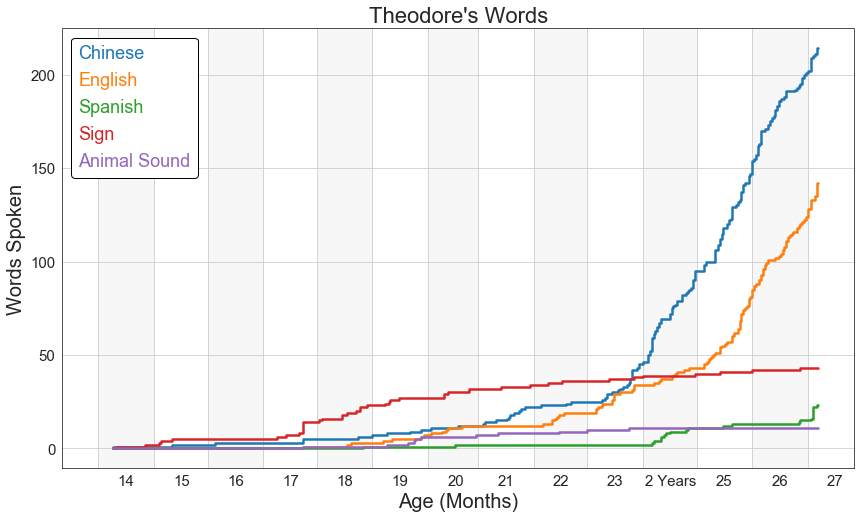

In [15]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

ax = make_plot_background(ax)

ax.set_yscale('linear')

ax.set_title("Theodore's Words", fontsize=22)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/theo_total_words_linear.{ext}".format(ext=ext), bbox_inches="tight")

Elephant Animal Sound


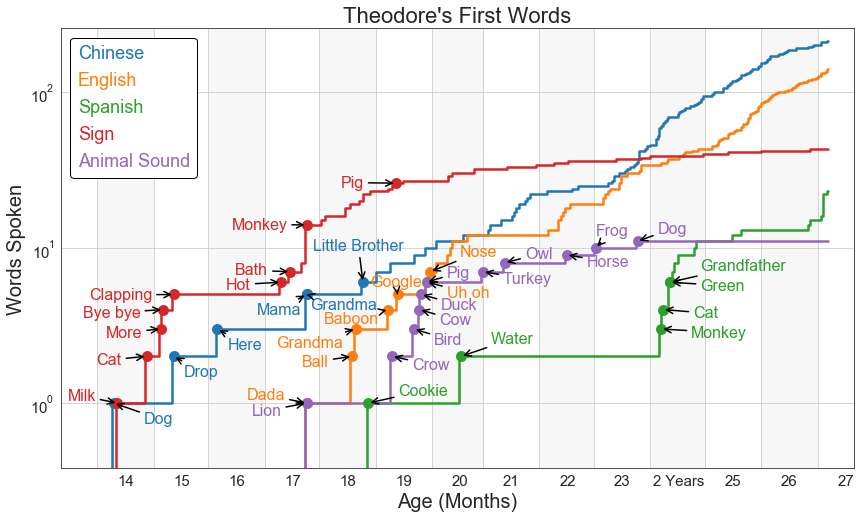

In [16]:
WORD_PAIRS = (
    #Chinese
    ("Dog",    "Chinese", (30, -20)),
    ("Drop", "Chinese", (10, -20)),
    ("Here",  "Chinese", (10, -20)),
    ("Grandma",   "Chinese", (4, -15)),
    ("Mama", "Chinese", (-50, -20)),
    ("Little Brother",  "Chinese", (-50, 32)),
    # English
    ("Dada",    "English", (-60, 4)),
    ("Ball", "English", (-50, -10)),
    ("Grandma",  "English", (-80, -18)),
    ("Baboon",   "English", (-65, -14)),
    ("Google",   "English", (-27.5, 8)),
    ("Uh oh",  "English", (20, -15)),
    ("Nose",  "English", (30, 15)),
    # Spanish
    ("Cookie", "Spanish", (30, 8)),
    ("Water",  "Spanish", (30, 13)),
    ("Monkey",   "Spanish", (30, -8)),
    ("Cat",   "Spanish", (30, -8)),
    ("Green",   "Spanish", (30, -8)),
    ("Grandfather",   "Spanish", (30, 12)),
    # Animal Sound
    ("Lion", "Animal Sound", (-55, -12)),
    ("Crow",  "Animal Sound", (20, -13)),
    ("Bird",   "Animal Sound", (20, -15)),
    ("Cow",   "Animal Sound", (20, -15)),
    ("Duck",   "Animal Sound", (20, -15)),
    ("Pig",   "Animal Sound", (20, 5)),
    ("Turkey",   "Animal Sound", (20, -12)),
    ("Owl",   "Animal Sound", (20, 4)),
    ("Horse",   "Animal Sound", (20, -12)),
    ("Frog",   "Animal Sound", (0, 12)),
    ("Dog",   "Animal Sound", (20, 8)),
    ("Elephant",   "Animal Sound", (20, -8)),
    # Sign
    ("Milk", "Sign", (-50, 3)),
    ("Cat",  "Sign", (-50, -8)),
    ("More",   "Sign", (-55, -8)),
    ("Bye bye",   "Sign", (-80, -8)),
    ("Clapping",   "Sign", (-85, -5)),
    ("Hot",   "Sign", (-55, -7)),
    ("Bath",   "Sign", (-55, -3)),
    ("Monkey",   "Sign", (-75, -4)),
    ("Pig",   "Sign", (-55, -4)),
)

fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

ax = make_plot_background(ax, WORD_PAIRS)

ax.set_title("Theodore's First Words", fontsize=22)

plt.xlim(X_MIN, X_MAX)
plt.ylim(Y_MIN, Y_MAX)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/theo_first_words.{ext}".format(ext=ext), bbox_inches="tight")